# TMDb Movie Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
This is a data analysis of the TMDb dataset which includes a large collection of movies. We'll clean the data, ask questions about it, answer it and conclude with the results.
There is also a machine learning model predicting revenue from the budget.

In [1]:
%%capture
!pip install pandas numpy matplotlib bs4 tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import re
from tqdm.notebook import tqdm

%matplotlib inline

In [74]:
plt.style.use(['seaborn-pastel'])

### Questions of the Analysis

**Q1- Do movies that people like have a higher revenue?<br>**
**Q2- Are action movies creating more revenue?<br>**
**Q3- Which year had most movies produced?<br>**
**Q4- Will investing more in a movie increase profit?<br>**

<a id='wrangling'></a>
## Data Wrangling

### Loading the dataset

In [235]:
df = pd.read_csv('tmdb-movies.csv')

The data is in CSV format, so we used the ```read_csv()``` function.

### Sampling the dataset

Sampling the data will give use some confidence when dealing with the data. Here, we'll sample 5 records.

In [236]:
df.sample(5)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
3061,14011,tt0902272,0.480116,3500000,5231128,Justice League: The New Frontier,David Boreanaz|Neil Patrick Harris|Brooke Shie...,http://www.dccomics.com/sites/newfrontier/,Dave Bullock,"We stand, today, on the edge of a new frontier...",...,The human race is threatened by a powerful cre...,75,Action|Adventure|Animation|Science Fiction,Warner Bros. Entertainment|DC Comics,2/26/08,66,6.3,2008,3.544753e+06,5.298017e+06
7967,9507,tt0088024,0.190287,0,0,Runaway,Tom Selleck|Cynthia Rhodes|Gene Simmons|Kirsti...,NaN,Michael Crichton,IT IS THE FUTURE. Machines are being programme...,...,"In the near future, a police officer specializ...",100,Thriller|Crime|Science Fiction,TriStar Pictures,12/14/84,31,4.7,1984,0.000000e+00,0.000000e+00
5975,194722,tt1483324,0.245457,2500000,0,At Middleton,Vera Farmiga|Andy GarcÃ­a|Taissa Farmiga|Spenc...,https://www.facebook.com/AtMiddleton,Adam Rogers,You never know what you'll discover on your fi...,...,Two parents fall in love over the course of a ...,101,Romance|Comedy,CineSon Entertainment|Look at the Moon Product...,5/17/13,29,6.0,2013,2.340083e+06,0.000000e+00
2557,13428,tt0145547,0.265623,0,0,Two Hands,Heath Ledger|Bryan Brown|Rose Byrne|David Fiel...,NaN,Gregor Jordan,"It was only one mistake, but it was a big one.",...,A 19 year old finds himself in debt to a local...,103,Comedy|Crime|Thriller,CML Films|Meridian Films,7/29/99,23,5.4,1999,0.000000e+00,0.000000e+00
1651,37178,tt1219836,0.381469,0,0,Virtuality,Nikolaj Coster-Waldau|Kerry BishÃ©|Joy Bryant|...,NaN,Peter Berg,Reality is only the beginning.,...,Twelve extremely talented men and women have b...,87,Drama|Romance|Science Fiction|Thriller,NaN,6/26/09,20,4.6,2009,0.000000e+00,0.000000e+00


By looking at the sample, we now have an idea of how the dataset is structured. One thing to be noticed is that 4 out of the 5 samples don't have a homepage. We will not need this data anyways, and will be removed later in the notebook. One other thing to notice is that some films have their budget and revenue set to 0. As this is unreasonable, we'll fetch the data from another source.<br>
<span style="color: red;"><b>NOTE THAT THIS MIGHT NOT APPLY TO ALL/CURRENT SAMPLES.</b></span>

### Understanding the data types present

In [237]:
df.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

Here, we see that all of the columns have the appropriate data type, so no need for conversion.

### Summary Statistics

In [238]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


Here, we see the issue of budget and revenue being zero too. We also see that there is a runtime of 0, but we will not be using runtime in our analysis.

### Counting Null Values

In [239]:
df.isna().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

Most fields are free from null values, though there are fields with them. To make sure that that is not a big proportion, we'll find out how big the dataset is:

In [240]:
len(df.index)

10866

This is not a big proportion, so we will not bother scraping or finding the values.

### Data Cleaning (Removing Unnecessary Columns and Filling Nulls)

In [241]:
df.drop(['runtime', 'tagline', 'overview', 'homepage', 'cast', 'director', 'keywords', 'overview', 'homepage', 'production_companies', 'popularity'], inplace=True, axis=1)

Here, we've removed all of the columns which are of no use to our questions. Next, we'll look at the null values issue.

In [242]:
df.isna().sum()

id                 0
imdb_id           10
budget             0
revenue            0
original_title     0
genres            23
release_date       0
vote_count         0
vote_average       0
release_year       0
budget_adj         0
revenue_adj        0
dtype: int64

Now, the null values problem is not a big issue anymore. We can ignore them now, as they don't have a big impact.

### Adding Missing Values

Next, we'll scrape the missing values for the budget and revenue from the TMDB site. It also converts the revenue to 2010 dollars.<br>
<span style="color: red;">**NOTE THAT RUNNING THE FOLLOWING CELL TAKES A VERY LONG TIME (1-2 HOURS). IF YOU WANT TO SKIP RUNNING IT, YOU CAN GET THE FILE WITH THE NEW DATA IN THE CELL LOADING FROM `scraped.csv`.**</span>

In [ ]:
for x in tqdm(range(len(df))):
    if df.iloc[x].budget == 0 or df.iloc[x].revenue == 0:
        try:
            website = 'https://www.themoviedb.org/movie/' + str(df.iloc[x].id)
            response = requests.get(website)
            content = response.text
            soup = BeautifulSoup(content, 'lxml')
            soup = soup.find('section', class_='left_column')
            if df.iloc[x].budget == 0:
                budget_soup = soup.find('p').findNext("p").findNext("p").get_text()
                budget = budget_soup[8:]
                factor = float(requests.get("https://www.statbureau.org/calculate-inflation-price-jsonp?country=united-states&start=" + str(df.iloc[x].release_year) + "/1/1&end=2010/1/1&amount=1&format=true").text[3:][:-2])
                if len(budget) != 0:
                    df.iloc.budget_adj = df.iloc[x].budget * factor
                    df[df.id == str(df.iloc[x].id)].budget = budget
            if df.iloc[x].revenue == 0:
                revenue_soup = soup.find('p').findNext("p").findNext("p").findNext("p").get_text()
                revenue = revenue_soup[9:]
                if len(revenue) != 0:
                    df[df.id == str(df.iloc[x].id)].revenue = revenue
                    df.iloc.revenue_adj = df.iloc[x].revenue * factor
        except:
            pass

In [131]:
df.to_csv('scraped.csv')

In [11]:
df = pd.read_csv('scraped.csv')

<a id='eda'></a>
## Exploratory Data Analysis

In [243]:
def custom_plot(df_col1, df_col2, title, x_title, y_title):
    """
    Input:
    
    df_co1: This column will represent the X-axis in the plot.
    df_co3: This column will represent the Y-axis in the plot.
    title: This is the title of the graph, which will be placed on the top of the graph.
    x_title: X-axis label
    y_title: Y-axis label
    
    Output:
    This function does not return a value. Instead, it plots a graph of the 2 variables given in, as 
    well as calculating the correlation using NumPy. A straight line is also drawn on the scatter 
    plot, with its m and b values printed above the plot.
    """
    m, b = np.polyfit(df_col1, df_col2, 1)
    x, y = df_col1, df_col2
    c = float(df_col1.corr(df_col2))
    plt.title(title + ', Correlation:' + "{:.2f}".format(c))
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.scatter(x, y, s=10);
    x = np.linspace(x.min(),x.max())
    plt.plot(x, m*x+b,'-r');
    plt.grid()
    print('gradient: ', m)
    print('y-intercept: ', b)

This is a custom function that'll be used throughout the analysis.

### Do movies that people like have a higher revenue?

gradient:  60347333.47509043
y-intercept:  -255984089.50878114


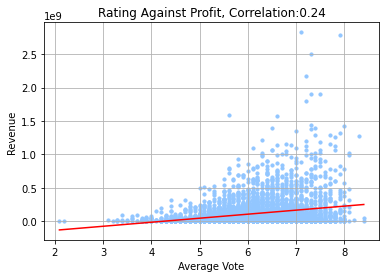

In [244]:
x = df[df['revenue'] != 0]['vote_average']
y = df[df['revenue'] != 0]['revenue_adj']
custom_plot(x, y, 'Rating Against Profit', 'Average Vote', 'Revenue')

The answer is not really. After calculating the correlation between both variables, it seems to be not closer to 0 than 1.

### Are action movies creating more revenue?

gradient:  -131770.85345528065
y-intercept:  355269866.9072296


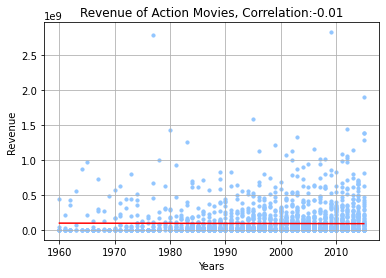

In [245]:
years = []
revenue = []
for x in range(len(df)):
    if 'Action' in str(df.iloc[x].genres):
        years.append(df.iloc[x].release_year)
        revenue.append(df.iloc[x].revenue_adj)

years = pd.Series(years)
revenue = pd.Series(revenue)
custom_plot(years, revenue, "Revenue of Action Movies", 'Years', 'Revenue')

A correlation of -0.01 shows that there is a stable market for action movies.

### Which year had most movies produced? (Single Variable Analysis)

In [231]:
print("The year with most releases is", str(int(df.release_year.mode())) + '.')

The year with most releases is 2014.


The mode is 2014.

### Will investing more in a movie increase profit?

gradient:  2.7260542335760505
y-intercept:  3519276.84040864


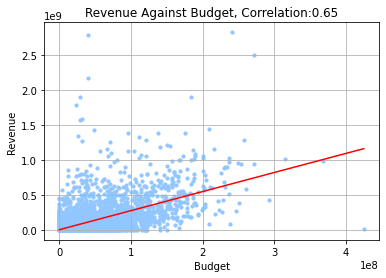

In [246]:
x = df['budget_adj']
y = df['revenue_adj']
custom_plot(x, y, "Revenue Against Budget", 'Budget', 'Revenue')

We have a strong correlation of 0.65. This shows that there is a positive relationship between the 2 variables. We can therefore create a machine learning model that can, to some degree, make a good estimate of the revenue with a given budget.

### Linear Regression | Predicting Revenue From a Given Budget

In [247]:
def revenue_from_budget(budget, revenue):
    predicted_revenue = 2.7260542335760505 * budget + 3519276.84040864
    # The values used above are from the plot above.
    print("Predicted Revenue:", predicted_revenue)
    print("Actual Revenue:", revenue)

In [203]:
point = 2

In [204]:
revenue_from_budget(df.iloc[point].budget_adj, df.iloc[point].revenue_adj)

Predicted Revenue: 279395843.8926138
Actual Revenue: 271619025.407628


In [249]:
total_square_distances = 0
for x in tqdm(range(len(df))):
    # This calculates the square distance of the point x from the prediction. Further down the cell, we calculate the mean.
    total_square_distances += ((2.7260542335760505 * df.iloc[x].budget_adj + 3519276.84040864) - df.iloc[x].revenue_adj) ** 2

mean_square_distance = total_square_distances / len(df)

  0%|          | 0/10866 [00:00<?, ?it/s]

Here, we calculate the mean squared error.

In [206]:
print('The Mean Square Distance:', mean_square_distance)

The Mean Square Distance: 1.2171362599546376e+16


To test out this model, change the value of `point` in order to see the model's prediction on the data we have.

<a id='conclusions'></a>
## Conclusions

In this analysis, we've first understood the data we've been given, then we've performed some analysis in order to answer the 4 questions we've came up with in the beginning. <br>
In summary, we found that if people don't like a film, that does not mean that it will not do well in terms of revenue. We've also found out that the year that movie production was at its peak was 2014, and that the action movie industry is a stable market where it is not affected as time has passed.

### Limitations

Since our data AND data source has a lot of incorrect values, it is impossible to conclude confidently the relationship between 2 or more variables.

### Improving/Additional Research

In order to improve this analysis, we can search for other sources of this same data that would provide us access, compare and perhaps concatenate them in order to have a more reliable data set to work with. Having this data would provide us the privilege to confidently show the relationships in the data.